<a href="https://colab.research.google.com/github/ykhoja/g20_profile_pic_maker/blob/main/g20_profile_pic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
""" 
Flow:
1) [DONE] User inputs twitter ID 
2) [DONE] Retrieve user image in original size
3) [DONE] Overlay G20 logo on top of it
4) [DONE] Show it to the user
"""

# Import libraries and authenticate twitter API

In [1]:
# Import needed libraries

from google.colab import drive  # to mount Google Drive to Colab notebook
import tweepy                   # Python wrapper around Twitter API
import matplotlib.pyplot as plt
import json
from PIL import Image
from PIL import ImageOps
import requests
from io import BytesIO
import numpy as np

In [121]:
from flask import Flask

In [2]:
# Mounting Google Drive

drive.mount('/content/gdrive')
path = './gdrive/My Drive/datasets/twitter_analysis/'

Mounted at /content/gdrive


In [3]:
# Load Twitter API secrets from an external file
secrets = json.loads(open(path + 'secrets.json').read())  

consumer_key = secrets['consumer_key']
consumer_secret = secrets['consumer_secret']
access_token = secrets['access_token']
access_token_secret = secrets['access_token_secret']

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)

api = tweepy.API(auth)

## Step 1) Specify twitter ID

In [112]:
# STEP 1 - USER INPUTS TWITTER ID

user_id = "yakhoja"

## Step 2) Retrieve profile pic in original size

In [137]:
def get_profile_pic(user_id):
  """ 
  Returns the original size twitter profile pic for a specified user
  Input: a specific user's twitter handle
  Output: the original size profile pic
  """
  user = api.get_user(user_id)
  profile_pic_url = user._json['profile_image_url']
  # Get URL for original size image by dropping "_normal.jpg" from URL
  profile_pic_url = profile_pic_url[:-11] + ".jpg"
  response = requests.get(profile_pic_url, stream=True).raw
  img = Image.open(response)
  return img

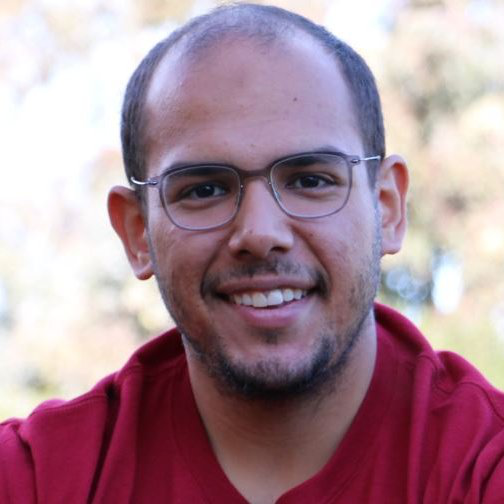

In [141]:
profile_pic = get_profile_pic(user_id)
profile_pic

## Step 3) Overlay G20 ribbon over image

In [138]:
ribbon = Image.open(path + "G20_ribbon_cropped.png")

In [90]:
def match_size(profile_pic, ribbon):
  w_pp, h_pp = profile_pic.size
  w_r , h_r  = ribbon.size

  if w_pp < w_r:
    factor = w_pp / w_r 
    h_r = int(h_r * factor)
    ribbon = ribbon.resize((w_pp, h_r))

  else:
    factor = w_r / w_pp 
    h_pp = int(h_pp * factor)
    profile_pic = profile_pic.resize((w_r, h_pp))

  return profile_pic, ribbon

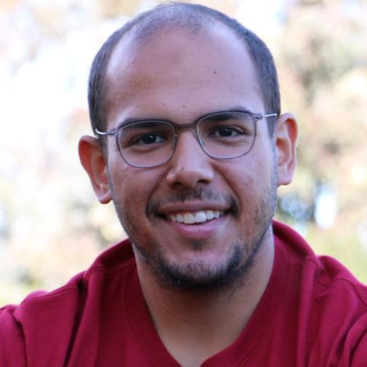

In [143]:
new_pp, new_r = match_size(profile_pic, ribbon)
new_pp

In [99]:
def place_ribbon(profile_pic, ribbon):
  w_pp, h_pp = profile_pic.size
  w_r , h_r  = ribbon.size

  if h_pp < h_r:
    factor = w_pp / w_r 
    h_r = int(h_r * factor)
    ribbon = ribbon.resize((w_pp, h_r))

  y = h_pp - h_r
  profile_pic.paste(ribbon, (0, y), mask=ribbon)

  return profile_pic

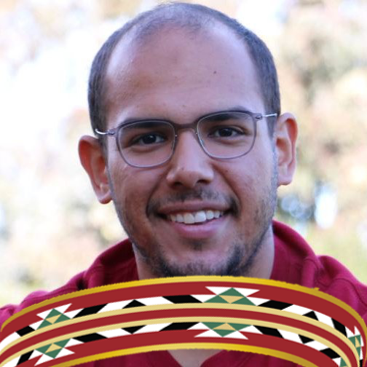

In [144]:
pp_w_r = place_ribbon(new_pp, new_r)
pp_w_r

In [167]:
def create_g20_pic(user_id):
  profile_pic = get_profile_pic(user_id)
  ribbon = Image.open(path + "G20_ribbon_cropped.png")
  new_pp, new_r = match_size(profile_pic, ribbon)
  pp_w_r = place_ribbon(new_pp, new_r)
  return pp_w_r

# Experiment with Flask

In [170]:
import io
from flask import send_file, send_from_directory

def serve_pil_image(pil_img):
    img_io = io.BytesIO()
    pil_img.save(img_io, 'JPEG', quality=70)
    img_io.seek(0)
    return send_file(img_io, mimetype='image/jpeg')

In [122]:
from google.colab.output import eval_js
print(eval_js("google.colab.kernel.proxyPort(5000)"))

https://dmm4rxr9y05-496ff2e9c6d22116-5000-colab.googleusercontent.com/


In [184]:
from flask import Flask, render_template, request
app = Flask(__name__, template_folder='gdrive/My Drive/datasets/g20/templates/')

@app.route("/")
def form():
    return render_template('form.html')

@app.route('/', methods=['POST'])
def my_form_post():
    text = request.form['text']
    user_id = text.lower()
    img = create_g20_pic(user_id)
    return serve_pil_image(img)
    
if __name__ == "__main__":
    app.run()

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)
127.0.0.1 - - [21/Nov/2020 20:39:41] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [21/Nov/2020 20:39:42] "GET /favicon.ico HTTP/1.1" 404 -
